In [1]:
#Import necessary libraries
import pandas as pd
import matplotlib as plt

#Import Data
tx_data=pd.read_excel("Online Retail.xlsx")
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
#Check the shape (number of columns and rows) in the dataset
tx_data.shape

(541909, 8)

In [3]:
def missing_values_table(df):
        #1 Total missing values
        mis_val = df.isnull().sum()
        
        #2 Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        #3 Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        #4 Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        #5 Only keep the columns with missing values
        mis_val_table_only = mis_val_table_ren_columns.loc[mis_val_table_ren_columns['% of Total Values'] > 0]
        
        #6 Return the dataframe with missing information
        return mis_val_table_only

In [4]:
missing = missing_values_table(tx_data)
missing_values_table(tx_data)

,Missing Values,% of Total Values
Description,1454,0.268311
CustomerID,135080,24.926694


In [5]:
#Remove time from date
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'], format="%m/%d/%Y %H:%M").dt.date

In [6]:
tx_data.dropna(subset=['CustomerID'], inplace=True)

In [7]:
#Keep records with non negative quantity
tx_data = tx_data[(tx_data['Quantity']>0)]

In [8]:
tx_data.shape

(397924, 8)

In [9]:
#Add a new column depicting total sales
tx_data['Total_Sales'] = tx_data['Quantity'] * tx_data['UnitPrice']
necessary_cols = ['CustomerID', 'InvoiceDate', 'Total_Sales']
tx_data = tx_data[necessary_cols]
tx_data.head()

,CustomerID,InvoiceDate,Total_Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [10]:
#Print records pertaining unique Customer IDs
tx_data['CustomerID'].nunique()

4339

In [11]:
#Check the Last order date
last_order_date = tx_data['InvoiceDate'].max()
print(last_order_date)

2011-12-09


In [12]:
from lifetimes.plotting import *
from lifetimes.utils import *
#Built-in utility functions from lifetimes package to transform the transactional data (one row per purchase) 
#into summary data (a frequency, recency, age and monetary)

In [13]:
lf_tx_data = summary_data_from_transaction_data(tx_data, 'CustomerID', 'InvoiceDate', monetary_value_col='Total_Sales', observation_period_end='2011-12-9')
lf_tx_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


- Recency: the age of the customer at the moment of his last purchase, which is equal to the duration between a customer’s first purchase and their last purchase.
- Frequency: the number of periods in which the customer has made a repeat purchase.
- Age of the customer (T): the age of the customer at the end of the period under study, which is equal to the duration between a customer’s first purchase and the last day in the dataset.

count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 35.7 %


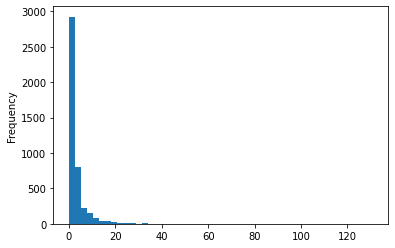

In [14]:
%matplotlib inline
#Create histogram to find out how many customers purchased item only once.
lf_tx_data['frequency'].plot(kind='hist', bins=50)
print(lf_tx_data['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(lf_tx_data['frequency'] == 0)/float(len(lf_tx_data))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

In [15]:
#Frequency/Recency Analysis Using the BG/NBD Model
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


In [16]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


alpha and r are for the Gamma distribution, and a and b for the Beta distribution. In the summary we also have a confidence interval for each parameter that we can use to compute a confidence interval of the expected future transactions for each customer.

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

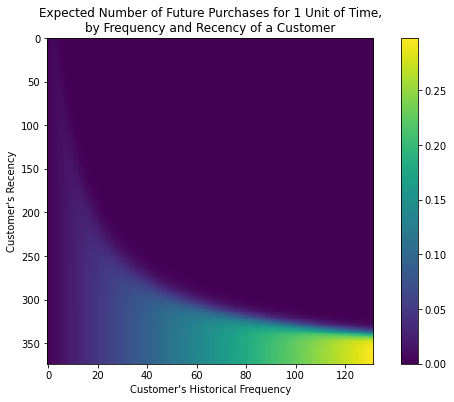

In [17]:
#Visualizing our frequency/recency matrix
%matplotlib inline
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

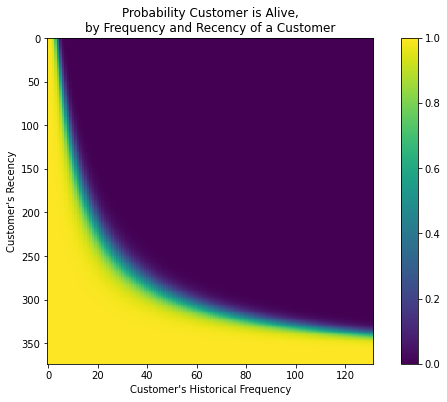

In [18]:
#predict if the customers are surely alive:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(10,6))
plot_probability_alive_matrix(bgf)

Indeed we see that if a customer has purchased more than 120 times and their latest purchase was when they were more than 350 days old (bottom right), then they are your hottest customers with the highest probability of being alive and purchasing. On the contrary, your coldest customers are in the top right corner: they bought a lot quickly, and we haven’t seen them in months.

In [19]:
#Predict future transaction in next 10 days i.e.top 10 customers that the model expects them to make purchases 
#in the next 10 days, based on historical data

t = 10
lf_tx_data['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T']),2)
lf_tx_data.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn
0,14911.0,131.0,372.0,373.0,1093.661679,2.98
1,12748.0,113.0,373.0,373.0,298.360885,2.58
2,17841.0,111.0,372.0,373.0,364.452162,2.53
3,15311.0,89.0,373.0,373.0,677.729438,2.03
4,14606.0,88.0,372.0,373.0,135.890114,2.01
5,12971.0,70.0,369.0,372.0,159.211286,1.61
6,13089.0,65.0,367.0,369.0,893.714308,1.50
7,14527.0,53.0,367.0,369.0,155.016415,1.23
8,13798.0,52.0,371.0,372.0,706.650962,1.20
9,16422.0,47.0,352.0,369.0,702.472340,1.09


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

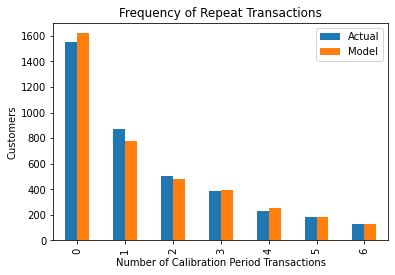

In [20]:
#Assessing model fit
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [21]:
#Customer's future transaction prediction for next 10 days
#The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time

t = 10
individual = lf_tx_data.loc[14911]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

#OBSERVATION: Our model predicts that customer 14911’s future transaction is appx 3 in 10 days.

2.9830238639043056

In [22]:
#Shortlist customers who had at least one repeat purchase with the company. 
shortlisted_customers = lf_tx_data[lf_tx_data['frequency']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

   CustomerID  frequency  recency      T  monetary_value  pred_num_txn
0     12347.0        6.0    365.0  367.0      599.701667          0.16
1     12348.0        3.0    283.0  358.0      301.480000          0.09
2     12352.0        6.0    260.0  296.0      368.256667          0.19
3     12356.0        2.0    303.0  325.0      269.905000          0.07
4     12358.0        1.0    149.0  150.0      683.200000          0.08
-----------------------------------------
The Number of Returning Customers are:  2790


In [23]:
shortlisted_customers

,frequency,recency,T,monetary_value,pred_num_txn
CustomerID,,,,,
12347.0,6.0,365.0,367.0,599.701667,0.16
12348.0,3.0,283.0,358.0,301.480000,0.09
12352.0,6.0,260.0,296.0,368.256667,0.19
12356.0,2.0,303.0,325.0,269.905000,0.07
12358.0,1.0,149.0,150.0,683.200000,0.08
...,...,...,...,...,...
18272.0,5.0,244.0,246.0,487.752000,0.18
18273.0,2.0,255.0,257.0,76.500000,0.09
18282.0,1.0,119.0,126.0,77.840000,0.09


In [24]:
shortlisted_customers['avg_monetary'] = shortlisted_customers['monetary_value'] / (shortlisted_customers['frequency']-1)

In [25]:
shortlisted_customers

,frequency,recency,T,monetary_value,pred_num_txn,avg_monetary
CustomerID,,,,,,
12347.0,6.0,365.0,367.0,599.701667,0.16,119.940333
12348.0,3.0,283.0,358.0,301.480000,0.09,150.740000
12352.0,6.0,260.0,296.0,368.256667,0.19,73.651333
12356.0,2.0,303.0,325.0,269.905000,0.07,269.905000
12358.0,1.0,149.0,150.0,683.200000,0.08,inf
...,...,...,...,...,...,...
18272.0,5.0,244.0,246.0,487.752000,0.18,121.938000
18273.0,2.0,255.0,257.0,76.500000,0.09,76.500000
18282.0,1.0,119.0,126.0,77.840000,0.09,inf


In [26]:
#Train gamma-gamma model by taking into account the monetary_value.
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(shortlisted_customers['frequency'],
        shortlisted_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [27]:
#After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. 
print(ggf.conditional_expected_average_profit(
        lf_tx_data['frequency'],
        lf_tx_data['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64


In [28]:
lf_tx_data['pred_txn_value'] = round(ggf.conditional_expected_average_profit(
        lf_tx_data['frequency'],
        lf_tx_data['monetary_value']), 2)
lf_tx_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value
0,12346.0,0.0,0.0,325.0,0.000000,0.02,416.92
1,12347.0,6.0,365.0,367.0,599.701667,0.16,569.99
2,12348.0,3.0,283.0,358.0,301.480000,0.09,333.76
3,12349.0,0.0,0.0,18.0,0.000000,0.10,416.92
4,12350.0,0.0,0.0,310.0,0.000000,0.02,416.92


In [29]:
#Calculate Customer Lifetime Value
lf_tx_data['CLV'] = round(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    lf_tx_data['frequency'],
    lf_tx_data['recency'],
    lf_tx_data['T'],
    lf_tx_data['monetary_value'],
    time=12, # months
    #discount_rate=0.01 # monthly discount rate ~ 12.7% annually
), 2)

#lf_tx_data.drop(lf_tx_data.iloc[:, 0:6], inplace=True, axis=1)

#lf_tx_data.sort_values(by='CLV', ascending=False).head(10).reset_index()

In [30]:
lf_tx_data

,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value,CLV
CustomerID,,,,,,,
12346.0,0.0,0.0,325.0,0.000000,0.02,416.92,295.25
12347.0,6.0,365.0,367.0,599.701667,0.16,569.99,3010.93
12348.0,3.0,283.0,358.0,301.480000,0.09,333.76,1008.69
12349.0,0.0,0.0,18.0,0.000000,0.10,416.92,1337.11
12350.0,0.0,0.0,310.0,0.000000,0.02,416.92,306.93
...,...,...,...,...,...,...,...
18280.0,0.0,0.0,277.0,0.000000,0.02,416.92,336.20
18281.0,0.0,0.0,180.0,0.000000,0.03,416.92,467.17
18282.0,1.0,119.0,126.0,77.840000,0.09,260.28,822.39
